Comme d'habitude, on importe les librairies et les modules dont on aura besoin

In [2]:
from math import sin,cos,log
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib  import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16


On va se concentrer sur le problème de l'avion en papier. Déterminons les constantes.

In [3]:
# model parameters:
g = 9.8      # gravity in m s^{-2}
v_t = 4.9    # trim velocity in m s^{-1}   
C_D = 1/5.0  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###
v0 = 6.5     # start at the trim velocity (or add a delta)
theta0 = -0.1 # initial angle of trajectory
x0 = 0.0     # horizotal position is arbitrary
y0 = 2.0     # initial altitude

Redéfinissons : 
- La fonction f(u) du right-hand side du modèle de phugoid complet
- La fonction qui fait avancer la solution d'un step selon la méthode d'Euler
- La fonction qui calculer les différences entre solutions

In [4]:
def f(u):
    v=u[0]
    theta=u[1]
    x=u[2]
    y=u[3]
    return numpy.array([-g*sin(theta)-C_D/C_L*g/v_t**2 *v**2,\
                       -g*cos(theta)/v+g/v_t**2*v,\
                       v*cos(theta),
                       v*sin(theta)])

In [5]:
def euler_step(u,f,dt):
    return u+dt*f(u)

In [30]:
def get_diffgrid(u_voulu,u_best,dt):
    N_voulu = len(u_voulu[:,0])
    N_best = len(u_best[:,0])
    
    ratio_taille_grille = int(numpy.ceil(N_best/N_voulu))  #ceil = plafond
    
    diffgrille=dt*numpy.sum(numpy.abs(u_voulu[:,2]-\
                                     u_best[::ratio_taille_grille,2]))
    return diffgrille

Définissons également la fonction rk2_step qui donne le "t" suivant en utilisant la méthode d'Euler modifée.

In [18]:
def rk2_step(u,f,dt):
    u_star= u + 0.5*dt*f(u)
    return u+dt*f(u_star)

À présent, déterminons le dt que l'on souhaite. Ensuite, on effectue les boucles sur la méthode d'Euler ET sur RK2 en même temps afin de les comparer par après.

In [19]:
T=15.0
dt=0.01
N=int(T/dt)+1     #nombre de time-steps

In [20]:
u_euler = numpy.empty((N,4))
u_rk2 = numpy.empty((N,4))

u_euler[0]= numpy.array([v0,theta0,x0,y0])
u_rk2[0]= numpy.array([v0,theta0,x0,y0])

In [21]:
for n in range (N-1):
    u_euler[n+1] = euler_step(u_euler[n],f,dt)
    u_rk2[n+1] = rk2_step(u_rk2[n],f,dt)

Allons puiser les morceaux des matrices qui nous intéressent : les positions x et y de chaque méthode.

In [22]:
x_euler=u_euler[:,2]
y_euler=u_euler[:,3]

x_rk2=u_rk2[:,2]
y_rk2=u_rk2[:,3]

On aimerait connaitre le moment où l'avion en papier touche le sol car après ça, les positions en y plus petit que zéro n'ont plus vraiment de sens physique.

Pour cela, on va utiliser la fonction numpy.where qui donne les indices des éléments dans un vecteur qui vérifient une certaine condition. Par exemple, 
         numpy.where(y_euler<0)[0]
donne un vecteur de tous les indices i tels que y_euler[i]<0.

On remarque que le [0] est nécessaire car cette fonction donne un vecteur qui ne contient qu'une seule ligne.

In [23]:
idx_negative_euler = numpy.where(y_euler<0.0)[0]

if len(idx_negative_euler)==0:
    idx_ground_euler= N-1
    print('La méthode Euler n a pas touché le sol!')
else:
    idx_ground_euler=idx_negative_euler[0]                                   

In [24]:
idx_negative_rk2 = numpy.where(y_rk2<0.0)[0]

if len(idx_negative_rk2)==0:
    idx_ground_rk2= N-1
    print('La méthode RK2 n a pas touché le sol!')
else:
    idx_ground_rk2=idx_negative_rk2[0]
                                    

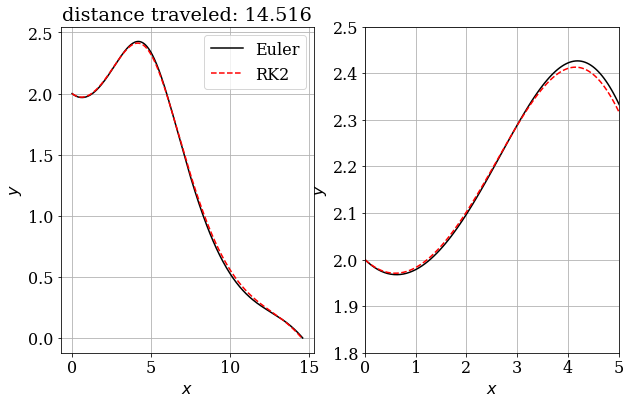

In [25]:
# plot the glider path
pyplot.figure(figsize=(10,6))
pyplot.subplot(121)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler], 'k-', label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2], 'r--', label='RK2')
pyplot.title('distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2-1]))
pyplot.legend();

# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_euler, y_euler, 'k-', label='Euler')
pyplot.plot(x_rk2, y_rk2, 'r--', label='RK2')
pyplot.xlim(0,5)
pyplot.ylim(1.8,2.5);

Etudions la convergence

In [26]:
# use a for-loop to compute the solution on different grids
dt_values = numpy.array([0.1, 0.05, 0.01, 0.005, 0.001])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N = int(T/dt)+1    # number of time-steps
    
    ### discretize the time t ###
    t = numpy.linspace(0.0, T, N)
    
    # initialize the array containing the solution for each time-step
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])

    # time loop
    for n in range(N-1):
        u[n+1] = rk2_step(u[n], f, dt)
    
    # store the value of u related to one grid
    u_values[i] = u

Calculons maintenant les différences entre solutions

In [31]:
diffgrid = numpy.empty_like(dt_values)
for i,dt in enumerate(dt_values):
    diffgrid[i]=get_diffgrid(u_values[i],u_values[-1],dt)

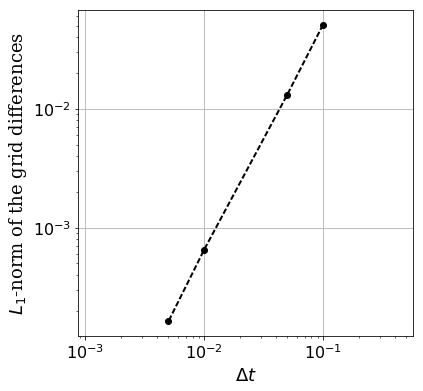

In [32]:
# plot using the matplotlib function loglog()
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=18)
pyplot.ylabel(r'$L_1$-norm of the grid differences', fontsize=18)
pyplot.xlim(1e-4,1)
pyplot.ylim(1e-4,1)
pyplot.axis('equal')
pyplot.loglog(dt_values[:-1], diffgrid[:-1], color='k', ls='--', lw=2, marker='o');

Regardons au taux de convergence. Comme c'est une méthode d'ordre 2, on s'attend à avoir au taux proche de 2. Ainsi, la solution numérique converge avec la résolution temporelle 2 fois plus vite que avec Euler.

In [33]:
# check convergence rate
r = 2
h = 0.001

dt_values = numpy.array([h, r*h, r**2*h])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N = int(T/dt)+1    # number of time-steps
    
    ### discretize the time t ###
    t = numpy.linspace(0.0, T, N)
    
    # initialize the array containing the solution for each time-step
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])

    # time loop
    for n in range(N-1):
        ### call rk2_step() ###
        u[n+1] = rk2_step(u[n], f, dt)
    
    # store the value of u related to one grid
    u_values[i] = u
    
# calculate the order of convergence
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) 
         - log(get_diffgrid(u_values[1], u_values[0], dt_values[1]))) / log(r)

print('The order of convergence is alpha = {:.3f}'.format(alpha))

The order of convergence is alpha = 1.983


METHODES MULTI-STEPS

In [34]:
def leapfrog_step(unm1,u,f,dt):
    return unm1+2.0*dt*f(u)

Avec cette méthode, il y a un problème pour la valeur initiale car il faut utiliser u_n-1 ! On va donc calculer u[1] avec RK2.

In [35]:
# model parameters:
g = 9.8      # gravity in m s^{-2}
v_t = 4.9    # trim velocity in m s^{-1}   
C_D = 1/5.0  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###
v0 = 6.5     # start at the trim velocity (or add a delta)
theta0 = -0.1 # initial angle of trajectory
x0 = 0.0     # horizotal position is arbitrary
y0 = 2.0     # initial altitude

# set time-increment and discretize the time
T  = 15.0                           # final time
dt = 0.01                             # set time-increment
N  = int(T/dt) + 1                   # number of time-steps

# set initial conditions
u_leapfrog = numpy.empty((N, 4))

# initialize the array containing the solution for each time-step
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])

# first step using RK2
u_leapfrog[1] = rk2_step(u_leapfrog[0], f, dt)

On peut maintenant poursuivre avec la méthode du saut de grenouille.

In [36]:
for n in range(1,N-1):
    u_leapfrog[n+1]=leapfrog_step(u_leapfrog[n-1],u_leapfrog[n],f,dt)

De nouveau, on extrait les positions x & y et l'information quant au moment au l'avion en papier va toucher le sol.

In [37]:
# get the glider position in time
x_leapfrog = u_leapfrog[:,2]
y_leapfrog = u_leapfrog[:,3]

# get the index of element of y where altitude becomes negative
idx_negative_leapfrog = numpy.where(y_leapfrog<0.0)[0]

if len(idx_negative_leapfrog)==0:
    idx_ground_leapfrog = N-1
    print ('Le saut de grenouille n a pas touché le sol!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

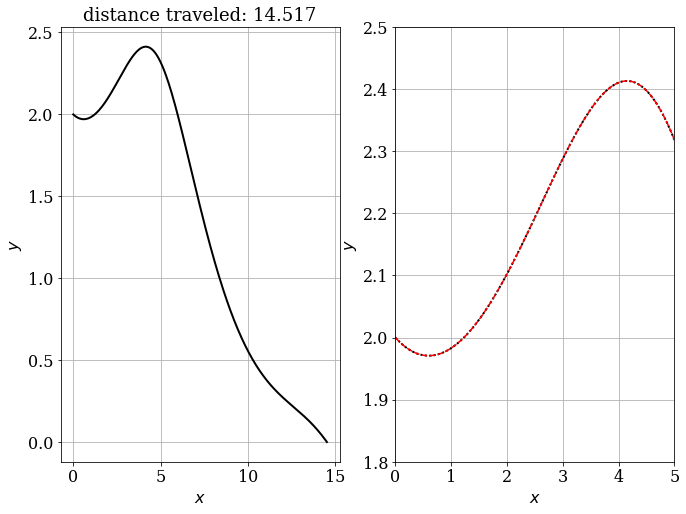

In [38]:
# plot the glider path
pyplot.figure(figsize=(11,8))
pyplot.subplot(121)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], color='k', ls='-', lw=2)
pyplot.title('distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog-1]), fontsize=18);

# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], color='k', ls=':', lw=2)
pyplot.plot(x_rk2, y_rk2, 'r--', label='RK2')
pyplot.xlim(0,5)
pyplot.ylim(1.8,2.5);

Calcul du taux de convergence

In [39]:
# check convergence rate
r = 2
h = 0.001

dt_values = numpy.array([h, r*h, r**2*h])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N = int(T/dt) + 1   # number of time-steps
    
    ### discretize the time t ###
    t = numpy.linspace(0.0, T, N)
    
    # initialize the array containing the solution for each time-step
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])

    # time loop
    u[1] = rk2_step(u[0], f, dt)
    for n in range(1, N-1):
        u[n+1] = leapfrog_step(u[n-1], u[n], f, dt)
    
    # store the value of u related to one grid
    u_values[i] = u
    
# calculate the order of convergence
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) 
         - log(get_diffgrid(u_values[1], u_values[0], dt_values[1]))) / log(r)

print('The order of convergence is alpha = {:.3f}'.format(alpha))

The order of convergence is alpha = 2.186


La méthode du saut de grenouille est donc d'ordre 2! 